In [1]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import esmlab
from glob import glob
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
import esmlab
import warnings
warnings.filterwarnings('ignore')
import ncar_jobqueue
from dask.distributed import Client
import cmocean

### Obs

In [2]:
ds = xr.open_mfdataset('/glade/work/kristenk/GLODAPv2_regridded/*.nc',decode_times=False,decode_coords=False)
ds = ds.rename({'depth_surface':'depth'})

In [3]:
ds.TAlk

<xarray.DataArray 'TAlk' (depth: 33, lat: 180, lon: 360)>
dask.array<open_dataset-1bba0a90c04574536a08fe0683569401TAlk, shape=(33, 180, 360), dtype=float32, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [4]:
Alk3=(ds.TAlk + 1.36 * ds.NO3)/ ds.salinity * 35

In [5]:
mean_tropAlk=Alk3.isel(depth=slice(0,3), lat=slice(60,120))
mean_tropAlk=mean_tropAlk.mean(dim='depth')
mean_tropAlk=mean_tropAlk.mean() 
#mean_tropAlk is 2300.4065

In [6]:
Alk_star=Alk3 - mean_tropAlk
ds['Alk_star'] = xr.DataArray(Alk_star,dims=('depth','lat','lon'))
ds['sPAlk'] = xr.DataArray(Alk3,dims=('depth','lat','lon'))

In [7]:
na = np.newaxis
pressure = sw.eos80.pres(ds.depth.values[:,na,na],ds.lat.values[na,:,na])
pDensity = sw.pden(ds.salinity, ds.temperature, pressure)-1000.

In [8]:
ds['pdens'] = xr.DataArray(pDensity,dims=('depth','lat','lon'))

In [9]:
area = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))

In [10]:
j=0

for lat in ds.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds['area']=area

In [11]:
def interp3d(coord_field,ds,new_levels,dim,**kwargs):
    '''kludged function for interpolation
    '''

    method = kwargs.pop('method','linear')
    if method == 'linear':
        from metpy.interpolate import interpolate_1d
        interp_func = interpolate_1d
    elif method == 'log':
        from metpy.interpolate import log_interpolate_1d
        interp_func = log_interpolate_1d

    newdim = new_levels.dims[0]

    dso = xr.Dataset()
    for v in ds.variables:

        if dim not in ds[v].dims:
            dso[v] = ds[v]
        else:

            dims_in = ds[v].dims
            if len(dims_in) == 1: continue

            interp_axis = dims_in.index(dim)
            dims_out = list(dims_in)
            dims_out[interp_axis] = newdim

            dso[v] = xr.DataArray(
                interp_func(new_levels.values,
                            coord_field.values,ds[v].values,axis=interp_axis),
                dims=dims_out,attrs=ds[v].attrs)
    dso[newdim] = new_levels
    return dso

In [12]:
sigma_coord = xr.DataArray(np.arange(25., 28., 0.1),dims='sigma')
ds_sigma = interp3d(ds.pdens,ds,sigma_coord,'depth',method='linear')

In [13]:
ds_sigma

<xarray.Dataset>
Dimensions:                 (lat: 180, lon: 360, sigma: 30)
Coordinates:
  * lat                     (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                     (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
  * sigma                   (sigma) float64 25.0 25.1 25.2 ... 27.7 27.8 27.9
Data variables:
    Cant                    (sigma, lat, lon) float64 nan nan nan ... nan 26.08
    CantInput_mean          (sigma, lat, lon) float64 nan nan nan ... nan nan
    NO3                     (sigma, lat, lon) float64 nan nan ... 12.09 12.46
    NO3Input_mean           (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaA                  (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaAInput_mean        (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaC                  (sigma, lat, lon) float64 nan nan nan ... nan nan
    OmegaCInput_mean        (sigma, lat, lon) float64 nan nan nan ... nan nan
    PI_TCO2                 (sigma, lat, lon) float64 nan nan ... 2.136e+03
    PI_TCO2Input_mean       (sigma, lat, lon) float64 nan nan nan ... nan nan
    PO4                     (sigma, lat, lon) float64 nan nan ... 0.8614 0.892
    PO4Input_mean           (sigma, lat, lon) float64 nan nan nan ... nan nan
    TAlk                    (sigma, lat, lon) float64 nan nan ... 2.291e+03
    TAlkInput_mean          (sigma, lat, lon) float64 nan nan nan ... nan nan
    TCO2                    (sigma, lat, lon) float64 nan nan ... 2.162e+03
    TCO2Input_mean          (sigma, lat, lon) float64 nan nan nan ... nan nan
    oxygen                  (sigma, lat, lon) float64 nan nan ... 308.6 308.0
    oxygenInput_mean        (sigma, lat, lon) float64 nan nan nan ... nan nan
    pHts25p0                (sigma, lat, lon) float64 nan nan ... 7.696 7.697
    pHts25p0Input_mean      (sigma, lat, lon) float64 nan nan nan ... nan nan
    pHtsinsitutp            (sigma, lat, lon) float64 nan nan nan ... nan nan
    pHtsinsitutpInput_mean  (sigma, lat, lon) float64 nan nan nan ... nan nan
    salinity                (sigma, lat, lon) float64 nan nan ... 34.72 34.72
    salinityInput_mean      (sigma, lat, lon) float64 nan nan nan ... nan nan
    silicate                (sigma, lat, lon) float64 nan nan nan ... nan 7.709
    silicateInput_mean      (sigma, lat, lon) float64 nan nan nan ... nan nan
    temperature             (sigma, lat, lon) float64 nan nan ... -0.3432
    temperatureInput_mean   (sigma, lat, lon) float64 nan nan nan ... nan nan
    Alk_star                (sigma, lat, lon) float64 nan nan ... 26.39 26.96
    sPAlk                   (sigma, lat, lon) float64 nan nan ... 2.327e+03
    pdens                   (sigma, lat, lon) float64 nan nan nan ... 27.9 27.9
    area                    (lat, lon) float64 216.3 216.3 ... -1.281e-09

In [14]:
picfile = '/glade/work/kristenk/satellite_data/processed/mean_PIC_annual_2002-2017_molm3.nc'
#picfile = '/glade/work/kristenk/satellite_data/cumulative_mean_pic/A20021852019334.L3m_CU_PIC_pic_9km.nc'
ds_pic = xr.open_dataset(picfile,decode_times=False,decode_coords=False)
ds_pic = ds_pic.rename({'z':'pic'})

In [15]:
picfile = '/glade/work/kristenk/satellite_data/cumulative_mean_pic/A20021852019334.L3m_CU_PIC_pic_9km.nc'
ds_pic2 = xr.open_dataset(picfile,decode_times=False,decode_coords=False)

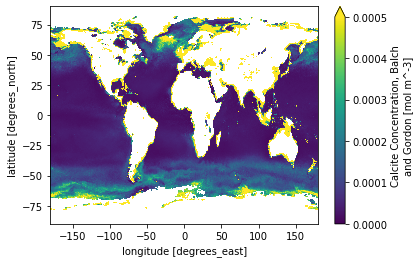

In [16]:
ds_pic.pic.plot(vmin=0,vmax=0.0005)

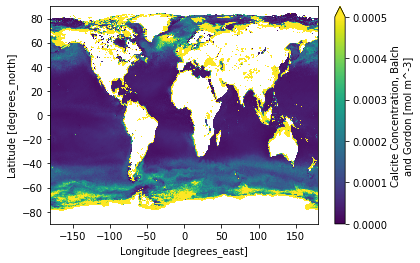

In [17]:
ds_pic2.pic.plot(vmin=0,vmax=0.0005)

In [18]:
sstfile = '/glade/work/kristenk/satellite_data/processed/mean_SST_annual_2002-2017.nc'
ds_sst = xr.open_dataset(sstfile,decode_times=False,decode_coords=False)
ds_sst = ds_sst.rename({'z':'sst'})

In [20]:
ds_sigma.sigma[18]

<xarray.DataArray 'sigma' ()>
array(26.8)
Coordinates:
    sigma    float64 26.8

In [21]:
MW2_sPAlk = ds_sigma.sPAlk.isel(sigma=slice(12,22)).mean(dim='sigma') * 1.026

In [22]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

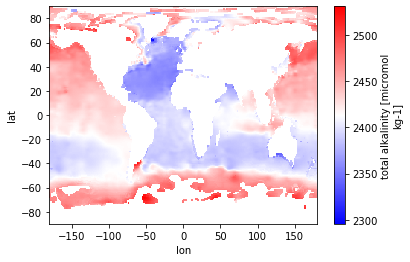

In [23]:
MW2_sPAlk.plot(cmap='bwr')

## CESM

### CESM with 2x calc ALK and DIC

In [24]:
variables = ['NO3','ALK','ALK_ALT_CO2','PD','SALT'] 

In [25]:
# case = 'cesm22cocco.G1850ECOIAF.T62_g17.004'
# path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
# coords = {'x':'TLONG','y':'TLAT'}
# keepthese = ['z_t','z_t_150m','time_bound','TAREA'] + variables
# keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [26]:
# %%time
# ds_list = []
# print(f'reading {case}')
# cesm_mon_ds2x = xr.Dataset()
# for v in variables:
    
#     print(v)   
#     files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))  
    
#     dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat='override', parallel=True, concat_dim="time",
#                        drop_variables=["transport_components", "transport_regions"], decode_times=True, chunks={'z_t' : 1})

#     cesm_mon_ds2x = xr.merge((cesm_mon_ds2x, dsv),compat='override')
#     ds_list.append(cesm_mon_ds2x)

In [27]:
# coords = {'x':'TLONG','y':'TLAT'}
# keepthese=['z_t','z_t_150m','time_bound','TAREA','NO3','ALK','ALK_ALT_CO2','PD','SALT']
# keep_vars = keepthese +list(coords.values())+['dz','KMT']
# cesm_mon_ds2x = cesm_mon_ds2x.drop([v for v in cesm_mon_ds2x.variables if v not in keep_vars])

In [28]:
# cesm_mon_ds2x

In [29]:
# cluster = ncar_jobqueue.NCARCluster(project='ncgd0011')
# cluster.adapt(minimum_jobs=0, maximum_jobs=30)
# client = Client(cluster)
# client

In [30]:
# %%time
# ds_annmean2x=cesm_mon_ds2x.mean(dim='time').compute() #rather read in file below


In [31]:
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.004/ocn/proc/mean5thIAF/mean_IAF5_alk_pd_sal_no3_004.nc'
#ds_annmean2x.to_netcdf(outfile)
ds_annmean2x = xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [32]:
ds_annmean2x

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
  * z_t          (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT          (nlat, nlon) float64 ...
    dz           (z_t) float32 ...
    TAREA        (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    NO3          (z_t, nlat, nlon) float32 ...
    ALK          (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2  (z_t, nlat, nlon) float32 ...
    PD           (z_t, nlat, nlon) float32 ...
    SALT         (z_t, nlat, nlon) float32 ...

In [33]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds_annmean2x.z_t

lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01
#ds_woa

In [34]:
Alk3_2x=(ds_annmean2x.ALK + 1.36 * ds_annmean2x.NO3)/ ds_annmean2x.SALT * 35.
ds_annmean2x['sPAlk']=xr.DataArray(Alk3_2x,dims=('z_t','nlat','nlon'))

In [35]:
Alk3_alt_2x=(ds_annmean2x.ALK_ALT_CO2 + 1.36 * ds_annmean2x.NO3)/ ds_annmean2x.SALT * 35.
ds_annmean2x['sPAlk_alt']=xr.DataArray(Alk3_alt_2x,dims=('z_t','nlat','nlon'))

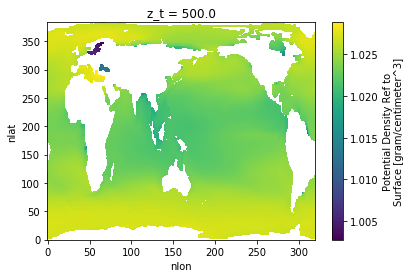

In [36]:
ds_annmean2x.PD.isel(z_t=0).plot()

In [37]:
ds_annmean2x['PD_sigma']=ds_annmean2x.PD*1000.-1000

In [39]:
sigma_coord = xr.DataArray(np.arange(25., 28., 0.1),dims='sigma')
ds_sigma_cesm2x = interp3d(ds_annmean2x.PD_sigma, ds_annmean2x, sigma_coord, 'z_t', method='linear')

In [40]:
ds_sigma_cesm2x

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, sigma: 30, z_t_150m: 15)
Coordinates:
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * sigma        (sigma) float64 25.0 25.1 25.2 25.3 ... 27.6 27.7 27.8 27.9
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 ...
    NO3          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK_ALT_CO2  (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    PD           (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    SALT         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    sPAlk        (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    sPAlk_alt    (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    PD_sigma     (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [41]:
MW2_sPAlk_cesm_alt2x = ds_sigma_cesm2x.sPAlk_alt.isel(sigma=slice(12,22)).mean(dim='sigma')

In [42]:
lon, lat, field_alt2x = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm_alt2x.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_alt2x = field_alt2x[sh, :]

### CESM with no calc ALK and DIC 

In [43]:
# case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
# path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
# coords = {'x':'TLONG','y':'TLAT'}
# keepthese = ['z_t','z_t_150m','time_bound','TAREA','NO3','coccoCaCO3','SALT','ALK','ALK_ALT_CO2','TEMP','PD']
# keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [44]:
# %%time
# ds_list = []
# print(f'reading {case}')
# cesm_mon_ds = xr.Dataset()
# for v in variables:
    
#     print(v)   
#     files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       
#     dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
#                        drop_variables=["transport_components", "transport_regions"], decode_times=True)

#     cesm_mon_ds = xr.merge((cesm_mon_ds, dsv))
#     ds_list.append(cesm_mon_ds)

In [45]:
# cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [46]:
# %%time
# ds_annmean=cesm_mon_ds.mean(dim='time').compute()

In [47]:
#write out annual means
outfile='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/annual_means.nc'
#ds_annmean.to_netcdf(outfile)

In [48]:
ds_annmean=xr.open_dataset(outfile,decode_times=False,decode_coords=False)

In [49]:
Alk3=(ds_annmean.ALK + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
ds_annmean['sPAlk']=xr.DataArray(Alk3,dims=('z_t','nlat','nlon'))

In [50]:
Alk3_alt=(ds_annmean.ALK_ALT_CO2 + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
ds_annmean['sPAlk_alt']=xr.DataArray(Alk3_alt,dims=('z_t','nlat','nlon'))

In [51]:
na = np.newaxis
pressure = sw.eos80.pres(ds_annmean.z_t.values[:,na,na]/100.,ds_annmean.TLAT.values[na,:,:])

In [52]:
#now calculate potential density
pDensity = sw.pden(ds_annmean.SALT, ds_annmean.TEMP, pressure)-1000.

In [53]:
ds_annmean['pdens'] = xr.DataArray(pDensity,dims=('z_t','nlat','nlon'))

In [54]:
sigma_coord = xr.DataArray(np.arange(25., 28., 0.1),dims='sigma')
ds_sigma_cesm = interp3d(ds_annmean.pdens, ds_annmean, sigma_coord, 'z_t', method='linear')

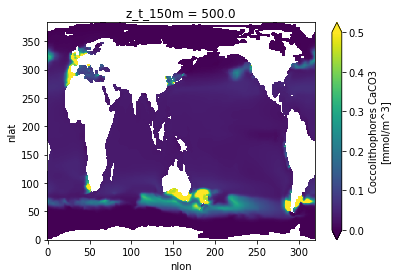

In [55]:
ds_annmean.coccoCaCO3.isel(z_t_150m=0).plot(vmin=0,vmax=0.5)

In [56]:
ds_sigma_cesm.sigma[29]

<xarray.DataArray 'sigma' ()>
array(27.9)
Coordinates:
    sigma    float64 27.9

In [57]:
ds_sigma_cesm

<xarray.Dataset>
Dimensions:      (d2: 2, nlat: 384, nlon: 320, sigma: 30, z_t_150m: 15)
Coordinates:
  * z_t_150m     (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
  * sigma        (sigma) float64 25.0 25.1 25.2 25.3 ... 27.6 27.7 27.8 27.9
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound   (d2) float64 ...
    TLONG        (nlat, nlon) float64 ...
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... nan nan nan
    KMT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    TEMP         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    SALT         (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    NO3          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK          (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    ALK_ALT_CO2  (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    coccoCaCO3   (z_t_150m, nlat, nlon) float32 ...
    sPAlk        (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    sPAlk_alt    (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    pdens        (sigma, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [58]:
ds_sigma_cesm.sigma[22]

<xarray.DataArray 'sigma' ()>
array(27.2)
Coordinates:
    sigma    float64 27.2

In [59]:
MW2_sPAlk_cesm = ds_sigma_cesm.sPAlk.isel(sigma=slice(12,22)).mean(dim='sigma')
MW2_sPAlk_cesm_alt = ds_sigma_cesm.sPAlk_alt.isel(sigma=slice(12,22)).mean(dim='sigma')

In [60]:
#lon, lat, field = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,sig268_sPAlk.values)
lon, lat, field = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

In [61]:
#lon, lat, field_alt = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,sig268_sPAlk_alt.values)
lon, lat, field_alt = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm_alt.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field_alt = field_alt[sh, :]

In [62]:
lon2, lat2, field2 = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values, ds_annmean.coccoCaCO3.isel(z_t_150m=0))
sh = lat2[:, 0] < 0
lon2 = lon2[sh, :]
lat2 = lat2[sh, :]
field2 = field2[sh, :]

# lon2, lat2, field2_nocalc = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values, ds_annmean.coccoCaCO3.isel(z_t_150m=0).where(ds_annmean.TLAT>-30.))
# field2_nocalc = field2_nocalc[sh, :]

# zero_calc = ds_annmean.coccoCaCO3.isel(z_t_150m=0) * 0.
# lon2, lat2, field2_zerocalc = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values, zero_calc.where(ds_annmean.TLAT<-30.))
# field2_zerocalc = field2_zerocalc[sh, :]

In [63]:
lon2, lat2, field3 = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values, ds_annmean.pdens.isel(z_t=0))
sh = lat2[:, 0] < 0
lon2 = lon2[sh, :]
lat2 = lat2[sh, :]
field3 = field3[sh, :]

### Put all maps together

#### Look at larger density range that contains more of the GCB: sigma 26.4 to 27.1

In [64]:
ds_sigma_cesm.sigma[12]

<xarray.DataArray 'sigma' ()>
array(26.2)
Coordinates:
    sigma    float64 26.2

In [65]:
MW2_sPAlk_cesm = ds_sigma_cesm.sPAlk.isel(sigma=slice(12,22)).mean(dim='sigma')
MW2_sPAlk_cesm_alt = ds_sigma_cesm.sPAlk_alt.isel(sigma=slice(12,22)).mean(dim='sigma')

In [66]:
lon, lat, field4 = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field4 = field4[sh, :]

In [67]:
lon, lat, field4_alt = adjust_pop_grid(ds_woa.TLONG.values, ds_woa.TLAT.values,MW2_sPAlk_cesm_alt.values)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field4_alt = field4_alt[sh, :]

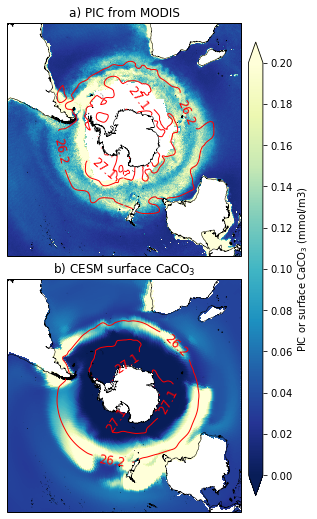

In [68]:
fig = plt.figure(figsize=(4,9))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
alk_min=2380
alk_max=2450
contour_specs = {'levels': [26.2,27.1]}

#---------- PIC from satellite
ax = fig.add_subplot(2,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('a) PIC from MODIS')
pc=ax.pcolormesh(ds_pic.lon, ds_pic.lat, 
                 ds_pic.pic.where(ds_sst.sst>2.)*1000, vmin=0, vmax=0.2, cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual PIC (mmol m$^{-3}$)')

cs = ax.contour(ds.lon.values,ds.lat.values,ds.pdens.isel(depth=0).values,
                colors='red',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)


#----------
ax = fig.add_subplot(2,1,2, projection=ccrs.SouthPolarStereo())
ax.set_title('b) CESM surface CaCO$_3$')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
pc=ax.pcolormesh(lon, lat, 
                 field2, vmin=0, vmax=0.2, cmap='YlGnBu_r',
                 transform=ccrs.PlateCarree())
#cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='Mean annual CaCO$_3$ (mmol m$^{-3}$)')

cs = ax.contour(lon,lat,field3,
                colors='red',
                levels = contour_specs['levels'],
                linewidths = 1,
                transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)




#fig.subplots_adjust(right=0.8,hspace=0.1)
fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)
cbar_ax = fig.add_axes([0.97, 0.15, 0.05, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='PIC or surface CaCO$_3$ (mmol/m3)',extend='both',ticks=np.arange(0,0.3,0.02))#,aspect=50)

#fig.subplots_adjust(hspace=0.1)



fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Fig2_leftside.pdf', bbox_inches='tight',format='pdf');



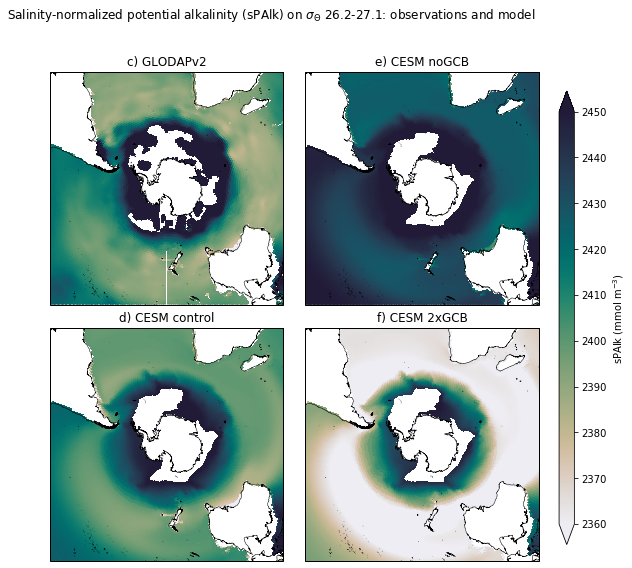

In [69]:
fig = plt.figure(figsize=(8.5,9))
fig.suptitle('Salinity-normalized potential alkalinity (sPAlk) on ${\sigma}_{\Theta}$ 26.2-27.1: observations and model', fontsize=12)
alk_min=2360
alk_max=2450
contour_specs = {'levels': [26.2,27.1]}

#---------- spALK from glodap
ax = fig.add_subplot(2,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) GLODAPv2')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 MW2_sPAlk, 
                 vmin=alk_min, vmax=alk_max, 
                 cmap=cmocean.cm.rain,
                 transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)


#----------spAlk from cesm no calc
ax = fig.add_subplot(2,2,2, projection=ccrs.SouthPolarStereo())
ax.set_title('e) CESM noGCB')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, field4_alt, cmap=cmocean.cm.rain,
                 vmin=alk_min, vmax=alk_max, 
                  transform=ccrs.PlateCarree())
plt.clabel(cs, colors = 'red', fmt = '%2.1f', fontsize=12)


#----------spAlk from cesm control
ax = fig.add_subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_title('d) CESM control')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, field4, cmap=cmocean.cm.rain,
                 vmin=alk_min, vmax=alk_max, 
                  transform=ccrs.PlateCarree())

#----------spAlk from cesm 2x calc
ax = fig.add_subplot(2,2,4, projection=ccrs.SouthPolarStereo())
ax.set_title('f) CESM 2xGCB')
ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

pc=ax.pcolormesh(lon, lat, field_alt2x, cmap=cmocean.cm.rain,
                vmin=alk_min, vmax=alk_max, 
                 transform=ccrs.PlateCarree())





#spAlk color bar
fig.subplots_adjust(right=0.95,wspace=0.025, hspace=0.1)
cbar_ax = fig.add_axes([0.97, 0.15, 0.025, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax,label='sPAlk (mmol m$^{-3}$)',extend='both') #,ticks=np.arange(0,0.3,0.02))#,aspect=50)

fig.savefig('/glade/u/home/kristenk/besome/alk_calc_paper/Figs/Fig2_rightside.pdf', bbox_inches='tight',format='pdf');


### how many mols of CaCO3 are there in each dataset?

In [68]:
ds_pic.pic.where(ds_sst.sst>2.)*1000

<xarray.DataArray 'pic' (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
Attributes:
    long_name:     Calcite Concentration, Balch and Gordon
    units:         mol m^-3
    actual_range:  [1.21238600e-05 2.42913105e-02]

In [69]:
ds_pic

<xarray.Dataset>
Dimensions:  (lat: 2160, lon: 4320)
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
Data variables:
    pic      (lat, lon) float32 ...
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        MODIS Level-3 Standard Mapped Image
    history:      grdmath total.nc 16 DIV = mean_PIC_annual_2002-2017_molm3.nc
    GMT_version:  4.5.18 [64-bit]

In [70]:
area = xr.DataArray(np.zeros([2160,4320]), dims=('lat','lon'))

In [ ]:
j=0

for lat in ds_pic.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds_pic['area']=area*1000000. #converting to m2

In [ ]:
ds_pic.area.plot()

In [ ]:
pic_SO_mol = ds_pic.pic.where(ds_sst.sst>2.).where(ds_pic.lat<-30.)
pic_SO_mol.plot(vmin=0,vmax=0.001)

In [ ]:
pic_sum = pic_SO_mol * ds_pic.area

pic_sum = pic_sum.sum(dim=('lon','lat'))

In [ ]:
pic_sum.values

In [ ]:
cesm_caco3_sum = ds_annmean.coccoCaCO3.isel(z_t_150m=0).where(ds_annmean.TLAT<-30.)/1000.
cesm_caco3_sum.plot(vmin=0,vmax=0.001)

In [ ]:
#sum CESM coccoCaCO3 in 1 meter deep of seawater

cesm_caco3_sum = cesm_caco3_sum * ds_annmean.TAREA/10000.
cesm_caco3_sum = cesm_caco3_sum.sum(dim=('nlon','nlat'))

In [ ]:
cesm_caco3_sum.values